# Lab Three: Extending Logistic Regression
## Caleb Moore, Blake Gebhardt, Christian Gould
dataset: https://www.kaggle.com/datasets/open-powerlifting/powerlifting-database

In [59]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import datasets
from numpy.linalg import pinv
import time
import matplotlib.pyplot as plt

In [27]:
# Notebook setup
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Preparation and Overview (3 points total)
* [2 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis? As in previous labs, also detail how good the classifier needs to perform in order to be useful.

# Background
### Where did our data come from?
* Our data came from the Open Powerlifting Databse. They are trying to create a database of powerlifting competitions for the public domain. The dataset that we are using here is a snapshot of what the database looked like as of April 2019. Powerlifting is a sport in which competitors compete to lift the most weight for their class in three separate barbell lifts: the Squat, Bench, and Deadlift. The dataset that we have here contains information about the competitors, the competitions, and the lifts that they performed.

### What could we do with this data?
* There is a lot of data that we can use here, but what we are more focused on is the prediction of the weight class of each person. If we can use data to predict with a very high accuracy what weight class a person should be in, it could be helpful in determining if someone is cheating or not. People could lie about their weight if there is not a weighing time. This could also show if someone is likely to be taking steroids. If they are classified as being far above the weight class than what they actually are, then investigators could look into the possiblity of them taking steroids.

### What is the task we are trying to solve?
* Given all the information that we have, specifically:
  * Sex
    * Sex has a large impact on how much the lifter can lift
  * Equipment
    * If the lifter uses straps or other apparatus, it can affect how much they can lift
  * Age
    * Age has a large impact on how much the lifter can lift
  * Division
    * A higher skill division can mean that the lifter can lift more
  * BodyweightKg
    * The actual weight of the lifter is a large factor in how much they can lift
  * Best3SquatKg
    * The best squat that the lifter did in 3 attempts
  * Best3BenchKg
    * The best bench that the lifter did in 3 attempts
  * Best3DeadliftKg
    * The best deadlift that the lifter did in 3 attempts
  * Tested
    * Whether or not the lifter was tested for drugs
  * Federation
    * The federation that held the competition

We want to be able to reliably predict what Weight Class that person should be in. The target column for that data is WeightClassKg.

The rest of the columns are not as important to us, so we will be dropping them.

The columns to be dropped are:
* Name
  * The name of the lifter is irrelevant to the weight class that they should be in
* Event
  * The federation that held the event is irrelevant to the weight class that they should be in
* TotalKg
  * The total weight lifted by the lifter. This is redundant since it is just the sum of the best squat, best bench, and best deadlift, which we already have
* AgeClass
  * Because we already have the age of the lifter, this column is redundant
* Squat1Kg - Squat4Kg
  * These are the individual squat attempts, we only really care about their best one
* Bench1Kg - Bench4Kg
  * These are the individual bench attempts, we only really care about their best one
* Deadlift1Kg - Deadlift4Kg
  * These are the individual deadlift attempts, we only really care about their best one
* Place
  * We don't need to know where the competition was held, just the results
* Wilks
  * This is a calculation of the total weight lifted in relation to the weight of the lifter, which is information we are already accounting for, so it would be redundant
* McCulloch
  * This is another calculation method like Wilks, and for the same reason as Wilks, we will not need this.
* Glossbrenner
  * This is another calculation method like Wilks, and for the same reason as Wilks, we will not need this.
* IPFPoints
  * This is a calculation of the total weight lifted in relation to the weight of the lifter, which is information we are already accounting for, so it would be redundant
* MeetCountry
  * We don't need to know where the competition was held, just the results
* MeetState
  * We don't need to know where the competition was held, just the results
* MeetName
  * We don't need to know the name of the meet, just what was lifted
* Country
  * We don't need to know where the lifter is from, just what they lifted
* Date
  * We don't need to know when the competition was held, just what was lifted

### What are we aiming for

* If we want our classifier to be reliable, we need to have at least 90% accuracy. If we can get to that, then we can be confident that we can use this classifier to determine if someone is possibly cheating or taking steroids. That level of accuracy would be very useful for investigators. 

### Things to note
* The full dataset has over 1.4 million rows of data, and that simply is more than we would like to operate on. We are going to shrink our dataset size down to 100k rows and deal with that data instead, in the interest of runtime


In [28]:
cols_to_drop = [
    'Name',
    'Event',
    'TotalKg',
    'AgeClass',
    'Squat1Kg',
    'Squat2Kg',
    'Squat3Kg',
    'Squat4Kg',
    'Bench1Kg',
    'Bench2Kg',
    'Bench3Kg',
    'Bench4Kg',
    'Deadlift1Kg',
    'Deadlift2Kg',
    'Deadlift3Kg',
    'Deadlift4Kg',
    'Place',
    'Wilks',
    'McCulloch',
    'Glossbrenner',
    'IPFPoints',
    'MeetCountry',
    'MeetState',
    'MeetName',
    'Country',
    'Date',
]

[.5 points] (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Provide a breakdown of the variables after preprocessing (such as the mean, std, etc. for all variables, including numeric and categorical).

# Initial Data Exploration
* We will start by importing the data and looking at the first few rows to get a feel for what we are working with.

* Some of the rows have NaN values, specifically in the 3 main lifts. We will give those NaN values a value of 0, since those people did not lift anything. Some of the meets did not have competitors do all 3 lifts, and we want to keep those rows, so we will just give them a value of 0 for that specific lift

* We will also drop the rows that have NaN values in the WeightClassKg column, since we want to predict that column.

* We took a look at how many weight classes there were, and there ended up being 13. A couple of the weight classes were in a different format, where it was 140+ or 110+ instead of the typical weight class, and we will leave those unaffected since some federations use that format.

In [29]:
# lets look at the data
df = pd.read_csv('./data/openpowerlifting.csv', nrows=100000)
# Drop the columns we don't need
df = df.drop(cols_to_drop, axis=1)
print(df.shape)
df.head()

(100000, 11)


,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Tested,Federation
0,F,Wraps,29.0,F-OR,59.8,60,105.0,55.0,130.0,NaN,GPC-AUS
1,F,Wraps,29.0,F-OR,58.5,60,120.0,67.5,145.0,NaN,GPC-AUS
2,F,Raw,40.0,F-OR,55.4,56,NaN,32.5,NaN,NaN,GPC-AUS
3,F,Wraps,23.0,F-OR,60.0,60,105.0,72.5,132.5,NaN,GPC-AUS
4,F,Wraps,45.0,F-OR,104.0,110,140.0,80.0,170.0,NaN,GPC-AUS


### Look at the types of Weight Classes
* There are a ton of weight classes, and we want to reduce the number of classes that we have. We will do this by combining weight classes into categories of 30s, so all values will become their nearest factor of 30.
* This is because these are really the only super relevant weight classes, and it will also make it easier to predict the weight class.
* Therefore we ended with a total of 5 possible weight classes, and we will use those as our target column.
* We decided to remove any rows that have a + at the end, since if the specification is something like 110+, then it is not a specific weight class, and we want to be able to predict a specific weight class.

In [30]:
# Lets look at some unique values that might be worth encoding, specifically our weight classes
print(df['WeightClassKg'].unique())
print("Original Number of Classes: ", len(df['WeightClassKg'].unique()))

# Remove all rows with a NaN value for weight class, since that is the value we are trying to predict
df = df.dropna(subset=['WeightClassKg'])

# All the rows with a + at the end do not give us enough information to predict the weight class.
# We will remove them
df = df[~df['WeightClassKg'].str.contains('\+')]

# Convert to float
df['WeightClassKg'] = df['WeightClassKg'].astype(float)

# Convert all values between factors of ten rounded up to the nearest factor of 30
df['WeightClassKg'] = df['WeightClassKg'].apply(lambda x: 30 * round(x / 30))

# Make it a string again so that it can be treated as a categorical variable
df['WeightClassKg'] = df['WeightClassKg'].astype(str)

# look at it real quick
print(df['WeightClassKg'].unique())
print("Total Number of Classes: ", len(df['WeightClassKg'].unique()))

['60' '56' '110' '75' '82.5' '52' '67.5' '90' '110+' '125' '100' '140'
 '140+' '48' '90+' '44' nan '105' '74' '93' '120+' '120' '63' '83' '84'
 '57' '72' '84+' '47' '59' '66' '53' '125+' '43' '100+' '90.7' '90.7+'
 '36' '40' '46' '49' '75+' '82.5+' '52+' '145' '145+' '72+' '93+' '60+'
 '50' '65' '80' '80+' '67.5+' '105+' '63+' '35' '155' '39' '155+' '68'
 '50.5' '55.5' '58.5' '70' '47.5' '136' '136+' '55' '54.4' '58.9' '63.5'
 '68.9' '78.9' '78.9+' '56.7' '83.9' '102' '113.4' '127' '127+' '117.5'
 '101' '103' '67' '82' '36.2' '52.5' '72.5' '81.6' '104.3' '117.9'
 '117.9+' '79.3' '113.4+' '49.9' '57.1' '70.3' '77.1' '92.9' '68.5' '69.5'
 '70.5' '71.5' '73.5' '74.5' '75.5' '76.5' '77.5' '78.5' '79.5' '80.5'
 '81.5']
Original Number of Classes:  113
['60' '120' '90' '150' '30']
Total Number of Classes:  5


### Tested Column
* This gives us information about whether the lifter was tested for drugs or not. We will convert this to a boolean column, where 1 means that they were tested, and 0 means that they were not tested. 

In [32]:
print(df['Tested'].unique())
# Convert NaN to 0, and 'Yes' to 1
df['Tested'] = df['Tested'].fillna(0)
df['Tested'] = df['Tested'].replace('Yes', 1)

df.head()

[0 1]


,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Tested,Federation
0,F,Wraps,29.0,F-OR,59.8,60,105.0,55.0,130.0,0,GPC-AUS
1,F,Wraps,29.0,F-OR,58.5,60,120.0,67.5,145.0,0,GPC-AUS
2,F,Raw,40.0,F-OR,55.4,60,NaN,32.5,NaN,0,GPC-AUS
3,F,Wraps,23.0,F-OR,60.0,60,105.0,72.5,132.5,0,GPC-AUS
4,F,Wraps,45.0,F-OR,104.0,120,140.0,80.0,170.0,0,GPC-AUS


### Look at the types of Divisions
  * We can turn these into one hot encoded columns, since they are representative of different categories.

In [33]:
print(df['Division'].unique())

# One hot encode that column
df = pd.get_dummies(df, columns=['Division'])
df.head()

['F-OR' 'M-OR' 'M-OE' 'F-OE' 'F-GR' 'F-JR' 'F-T3R' 'F-T2R' 'F-M5R' 'F-M1R'
 'F-M2R' 'F-T1R' 'F-M3R' 'M-JR' 'M-M3R' 'M-M1R' 'M-M2R' 'M-T2R' 'M-T1R'
 'M-M6R' 'M-T3R' 'M-M4R' 'M-M5R' 'M-TR' 'M-JE' 'F-TR' 'F-M4R' 'F-M7R'
 'M-M8R' 'Youth A' 'Juniors' 'Open' 'Masters 1' 'Masters 4' 'Masters 2'
 'Youth B' 'Masters 3' 'Sub-Juniors' 'Youth' 'Teen' 'M1' 'M5' 'M4' 'M2'
 'M3' nan 'Teen 18-19' 'Juniors 20-23' 'Teen 16-17' 'Masters 40-44'
 'Masters 50-54' 'Teen 3' 'Teen 2' 'Masters' 'Teen 1' 'Masters 60-64'
 'Submasters 35-39' 'Masters 55-59' 'Police/Fire' 'Teen 13-15'
 'Submasters 33-39' 'Masters 45-49' 'Masters 65-69' 'Masters 70-74'
 'Juniors 19-20' 'Military' 'Teen 15-16' 'Juniors 21-23' 'Masters 75-79'
 'Teen 14-15' 'Masters 80+' 'Masters 40+' 'M-O' 'F-O' 'F-J' 'F-T2' 'F-T1'
 'F-M1' 'M-T1' 'F-M2' 'M-T2' 'M-J' 'M-M1' 'M-T3' 'M-M5' 'M-M2' 'M-EM6'
 'M-M4' 'M-M3' 'M-SM' 'M-M6' 'F-SM' 'M-EM2' 'M-EM1' 'M-H' 'M-M' 'M-B'
 'F-H' 'F-L' 'M-L' 'F-MW' 'F-LW' 'M-LW' 'M-MW' 'M-HW' 'F-HW' 'M-Hw' 'F-B'
 'M-HWB'

,Sex,Equipment,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Tested,Federation,...,Division_Youth A,Division_Youth B,Division_law,Division_pro Masters 55-59,Division_Девушки,Division_М1,Division_М2,Division_М3,Division_Юниорки,Division_Юноши
0,F,Wraps,29.0,59.8,60,105.0,55.0,130.0,0,GPC-AUS,...,0,0,0,0,0,0,0,0,0,0
1,F,Wraps,29.0,58.5,60,120.0,67.5,145.0,0,GPC-AUS,...,0,0,0,0,0,0,0,0,0,0
2,F,Raw,40.0,55.4,60,NaN,32.5,NaN,0,GPC-AUS,...,0,0,0,0,0,0,0,0,0,0
3,F,Wraps,23.0,60.0,60,105.0,72.5,132.5,0,GPC-AUS,...,0,0,0,0,0,0,0,0,0,0
4,F,Wraps,45.0,104.0,120,140.0,80.0,170.0,0,GPC-AUS,...,0,0,0,0,0,0,0,0,0,0


### Federation
* Federations clearly are a categorical datatype, so we will one hot encode them as well.

In [34]:
print(df['Federation'].unique())

# One Hot Encode the Federation column
df = pd.get_dummies(df, columns=['Federation'])
df.head()

['GPC-AUS' 'BVDK' 'GPU' 'GPA-CRO' 'USPF' 'RhinoPC' 'RUPC' 'ACHIPO'
 'USSports' 'UkrainePF' 'UkrainePA' 'WPF' 'USA-UA' 'ADFPA' 'JPA'
 'WPC-Germany' 'PLZS' 'NORCAL' 'WelshPA' 'SSA' 'APA' 'WPA' 'WRPF-KAZ'
 'WUAP-AUT' 'WRPF-POL' 'IPL-NZ' 'APF' 'USMilAbroad' 'AAU' 'BAWLA' 'IPF'
 'PA' 'NZPF' 'AusPF' 'WDFPF' 'IPA' 'WNPF' 'SCI' 'WPC' 'AAPLF' 'SLP'
 'IrishPF' 'CAPO' 'UPA' 'IBSA' 'WABDL' 'ScottishPL' 'EPF' 'AIWBPA' 'BDFPA'
 'NASA' 'BPO' 'USAPL' 'OceaniaPF' 'FPR' 'USARawBP' 'AusDFPF' 'THSPA'
 'BBDD' 'BPF' 'WBC']


,Sex,Equipment,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Tested,Division_0/60,...,Federation_WDFPF,Federation_WNPF,Federation_WPA,Federation_WPC,Federation_WPC-Germany,Federation_WPF,Federation_WRPF-KAZ,Federation_WRPF-POL,Federation_WUAP-AUT,Federation_WelshPA
0,F,Wraps,29.0,59.8,60,105.0,55.0,130.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,F,Wraps,29.0,58.5,60,120.0,67.5,145.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,F,Raw,40.0,55.4,60,NaN,32.5,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,F,Wraps,23.0,60.0,60,105.0,72.5,132.5,0,0,...,0,0,0,0,0,0,0,0,0,0
4,F,Wraps,45.0,104.0,120,140.0,80.0,170.0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Look at the Equipment
* Since there are only a few options, we can one-hot encode that column

In [35]:
print(df['Equipment'].unique())

# One hot encode that column
df = pd.get_dummies(df, columns=['Equipment'])
df.head()

['Wraps' 'Raw' 'Single-ply' 'Multi-ply' 'Straps']


,Sex,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Tested,Division_0/60,Division_13-16,...,Federation_WPF,Federation_WRPF-KAZ,Federation_WRPF-POL,Federation_WUAP-AUT,Federation_WelshPA,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Straps,Equipment_Wraps
0,F,29.0,59.8,60,105.0,55.0,130.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,F,29.0,58.5,60,120.0,67.5,145.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,F,40.0,55.4,60,NaN,32.5,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,F,23.0,60.0,60,105.0,72.5,132.5,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,F,45.0,104.0,120,140.0,80.0,170.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Sex
* Since there are only two options here, we will one-hot encode this column as well

In [36]:
print(df['Sex'].unique())

# One hot encode that column
df = pd.get_dummies(df, columns=['Sex'])
df.head()

['F' 'M']


,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Tested,Division_0/60,Division_13-16,Division_14-16,...,Federation_WRPF-POL,Federation_WUAP-AUT,Federation_WelshPA,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Straps,Equipment_Wraps,Sex_F,Sex_M
0,29.0,59.8,60,105.0,55.0,130.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,29.0,58.5,60,120.0,67.5,145.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,40.0,55.4,60,NaN,32.5,NaN,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,23.0,60.0,60,105.0,72.5,132.5,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,45.0,104.0,120,140.0,80.0,170.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


### Removing NaN values in the 3 main lifts
* Some of the competitions made it so that the competitors did not have to compete in all 3 lifts, so we will give those NaN values a value of the average for that weight class, since those people did not lift anything. It would scew the data pretty horribly if we just gave them a value of 0, since that would mean that they lifted 0kg in that lift, which is not true.

* The other option, removing that row, is not really an option because then we get left with a pretty small dataset, with only a few rows (around 5 haha!)

In [37]:
# Make all Nan values the average of the column for that person's weight class
df['Best3SquatKg'] = df.groupby('WeightClassKg')['Best3SquatKg'].transform(lambda x: x.fillna(x.mean()))
df['Best3BenchKg'] = df.groupby('WeightClassKg')['Best3BenchKg'].transform(lambda x: x.fillna(x.mean()))
df['Best3DeadliftKg'] = df.groupby('WeightClassKg')['Best3DeadliftKg'].transform(lambda x: x.fillna(x.mean()))

### Removing NaN values in the Age column
* Some of the entries did not have an Age column, and that is something we find very important to the weight class that they should be in, so we will remove those rows.

In [38]:
# Remove NaN in Age column
df = df.dropna(subset=['Age'])

### Scaling the data
* We will scale the data using the StandardScaler, since it is a good way to scale the data without distorting the shape of the data.

* The types of data that we need to scale are the Age, BodyweightKg, Best3SquatKg, Best3BenchKg, and Best3DeadliftKg columns. We will scale those columns, and then we will concatenate them with the other columns that we have already one-hot encoded.

In [39]:
# Declare the StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scale the Age Column
df['Age'] = scaler.fit_transform(df['Age'].values.reshape(-1, 1))

# Scale the BodyweightKg Column
df['BodyweightKg'] = scaler.fit_transform(df['BodyweightKg'].values.reshape(-1, 1))

# Scale the Best3SquatKg Column
df['Best3SquatKg'] = scaler.fit_transform(df['Best3SquatKg'].values.reshape(-1, 1))

# Scale the Best3BenchKg Column
df['Best3BenchKg'] = scaler.fit_transform(df['Best3BenchKg'].values.reshape(-1, 1))

# Scale the Best3DeadliftKg Column
df['Best3DeadliftKg'] = scaler.fit_transform(df['Best3DeadliftKg'].values.reshape(-1, 1))

df.head()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Tested,Division_0/60,Division_13-16,Division_14-16,...,Federation_WRPF-POL,Federation_WUAP-AUT,Federation_WelshPA,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Straps,Equipment_Wraps,Sex_F,Sex_M
0,-0.159545,-0.997664,60,-1.324652,-1.395555,-1.278240,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,-0.159545,-1.062647,60,-1.092358,-1.151556,-1.013500,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0.635782,-1.217606,60,-0.617433,-1.834752,-0.626826,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,-0.593359,-0.987667,60,-1.324652,-1.053956,-1.234117,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0.997294,1.211747,120,-0.782633,-0.907557,-0.572267,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


[.5 points] Divide your data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?

* Using an 80/20 split makes sense, as we have a large dataset with a lot of features. We want to make sure that we have enough data to train our model, but we also want to make sure that we have enough data to test it as well. We don't want to overfit our model as a result of using too little data, so we will stick with the 80/20 split.

In [40]:
# Get the X and y values
X = df.drop('WeightClassKg', axis=1)
y = df['WeightClassKg']

### Using train_test_split from sklearn

In [41]:
print('original shapes')
print('X:', df.shape)
print('y:', df.shape)
print()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('train shapes')
print('X:', X_train.shape)
print('y', y_train.shape)
print()

print('test shapes')
print('X:', X_test.shape)
print('y:', y_test.shape)

original shapes
X: (68416, 501)
y: (68416, 501)

train shapes
X: (54732, 500)
y (54732,)

test shapes
X: (13684, 500)
y: (13684,)


# Modeling (5 points total)
The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited. 

[2 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:

* Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and {Newton's method/Quasi Newton methods}. 
* Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.

In [42]:
from IPython.display import clear_output
"""
@Params:
    learning_rate: The learning rate for the model
    n_iters: The number of iterations to run the model
    type: The type of model to run, either 'stochastic_gradient_descent', 'newton', or 'steepest_ascent'
    cost: variable cost for the model
    method: The method to use for the model, either 'ovr' or 'ovo'. OVR is one vs rest, OVO is one vs one
"""
class LRC:
    def __init__(self, learning_rate=0.01, n_iters=1000, type='stochastic_gradient_descent', cost=0, method='ovr'):
        self.lr = learning_rate
        # Number of iterations is initially 1000
        self.n_iters = n_iters
        # The weights will be made later as well as the bias, whenever we fit
        self.weights = []
        self.bias = []
        self.colNames = []
        self.type = type
        self.binary_encoder_num = 0
        self.cost = cost
        self.method = method

    """
    Fit function.
    X: The feature matrix
    y: The target vector
    """
    def fit(self, X, y):
      if self.method == 'ovr':
        # Split the y data to be one hot encoded
        y_df = pd.DataFrame(y)
        one_hot_ys = []
        # One hot encode the y
        y_df = pd.get_dummies(y_df)
        y_df_colNames = y_df.columns
        self.colNames = y_df_colNames

        for col in y_df_colNames:
          one_hot_ys.append(y_df[col])

        for this_y in one_hot_ys:
          if self.type == 'stochastic_gradient_descent':
            w, b = self.stochastic_gradient_descent(X, this_y)
            self.weights.append(w)
            self.bias.append(b)

          elif self.type == 'newton':
            w, b = self.newton_method(X, this_y)
            self.weights.append(w)
            self.bias.append(b)

          elif self.type == 'steepest_ascent':
            w, b = self.steepest_ascent(X, this_y)
            self.weights.append(w)
            self.bias.append(b)

          else:
            print('Invalid algorithm')
            return

          self.binary_encoder_num += 1

      elif self.method == 'ovo':
        # Split the y data
        y_df = pd.DataFrame(y)

        ys_to_classify = []
        xs_for_classify = []

        # One hot encode the y
        y_df = pd.get_dummies(y_df)

        # Get target vectors for each class against each other
        for i in range(len(y_df.columns)):
           for j in range(i + 1, len(y_df.columns)):
              if i != j:
                sub_x = X.copy()
                self.colNames.append(y_df.columns[i] + '|' + y_df.columns[j])
                # Make a new target vector where 1 is the ith class and 0 is the jth class
                new_y = y_df[y_df.columns[i]] - y_df[y_df.columns[j]]

                # Remove all the rows that are 0 both in new_y and from sub_x
                sub_x = sub_x[new_y != 0]
                new_y = new_y[new_y != 0]

                # Replace all the -1s with 0s
                new_y = new_y.replace(-1, 0)
                # Add the new y to the list of y's to classify
                ys_to_classify.append(new_y)
                xs_for_classify.append(sub_x)

        for this_y, this_X in zip(ys_to_classify, xs_for_classify):
          if self.type == 'stochastic_gradient_descent':
            print("shapes: ", this_X.shape, this_y.shape)
            w, b = self.stochastic_gradient_descent(this_X, this_y)
            self.weights.append(w)
            self.bias.append(b)

          elif self.type == 'newton':
            w, b = self.newton_method(this_X, this_y)
            self.weights.append(w)
            self.bias.append(b)

          elif self.type == 'steepest_ascent':
            w, b = self.steepest_ascent(this_X, this_y)
            self.weights.append(w)
            self.bias.append(b)

          else:
            print('Invalid algorithm')
            return

          self.binary_encoder_num += 1

    # Basic sigmoid function found online:
    # https://en.wikipedia.org/wiki/Sigmoid_function
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def basicLoss(self, y, y_pred):
       return (y_pred - y)

    # Calculate the difference between the predicted and actual values for the loss function
    def calcLoss(self, y, y_pred):
        return self.basicLoss(y, y_pred)

    def calcGradient(self, X, y, weights, bias):
       ydiff = y - self.predict_y(X, weights, bias).ravel()
       gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)

       gradient = gradient.reshape(weights.shape)
       # Add the regularization
       gradient[:] += -2 * weights[:] * self.cost

       return gradient, ydiff

    def calcHessianGradient(self, X, y, weights, bias):
      g = self.predict_y(X, weights, bias).ravel()

      hessian = X.T @ np.diag(g * (1 - g)) @ X - 2 * self.cost

      ydiff = y - g

      gradient = np.sum(X * ydiff[:, np.newaxis], axis=0)
      gradient = gradient.reshape(weights.shape)

      # Add the regularization
      gradient[:] += -2 * weights[:] * self.cost

      return pinv(hessian) @ gradient, ydiff

    def predict_y(self, X, weights, bias):
       return self.sigmoid(X @ (weights + bias))

    def newton_method(self, X, y):
      # Make sure X and y are numpy arrays
      X = np.array(X)
      y = np.array(y)
      
      n_samples, n_features = X.shape

      these_weights = np.zeros(n_features)
      this_bias = 0

      for i in range(self.n_iters):
          clear_output(wait=True)
          print("encoderNum: ", self.binary_encoder_num + 1)
          print("iter: ", i)

          gradient, loss = self.calcHessianGradient(X, y, these_weights, this_bias)

          # Calculate the gradient of the bias
          db = (1 / n_samples) * np.sum(loss)

          # Update the weights and bias
          these_weights += self.lr * (gradient)
          this_bias += self.lr * db

      clear_output(wait=True)

      return these_weights, this_bias
      
    def stochastic_gradient_descent(self, X, y):
      # Make sure X and y are numpy arrays
      X = np.array(X)
      y = np.array(y)
      
      n_samples, n_features = X.shape

      these_weights = np.zeros(n_features)
      this_bias = 0
      
      for i in range(self.n_iters):
          if (i % 1000 == 0):
            clear_output(wait=True)
            print("encoderNum: ", self.binary_encoder_num + 1)
            print("iter: ", i)

          # Get a random sample from the X and y
          random_index = np.random.randint(0, n_samples)
          X_sample = X[random_index]
          y_sample = y[random_index]

          gradient, loss = self.calcGradient(X_sample, y_sample, these_weights, this_bias)

          # Calculate the gradient of the bias
          db = (1 / n_samples) * np.sum(loss)

          # Update the weights and bias
          these_weights += self.lr * (gradient)
          this_bias += self.lr * db

      clear_output(wait=True)
        
      return these_weights, this_bias
    
    def steepest_ascent(self, X, y):
        # Make sure X and y are numpy arrays
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape

        these_weights = np.zeros(n_features)
        this_bias = 0
        
        for i in range(self.n_iters):
            if (i % 2 == 0):
              clear_output(wait=True)
              print("encoderNum: ", self.binary_encoder_num + 1)
              print("iter: ", i)

            gradient, loss = self.calcGradient(X, y, these_weights, this_bias)

            db = (1 / n_samples) * np.sum(loss)
            
            these_weights += self.lr * (gradient)
            this_bias += self.lr * db
        
        clear_output(wait=True)

        return these_weights, this_bias

    def predict(self, X):

        # Get the list of linear models to be used to predict the y values
        y_predicteds = []
        for w, b in zip(self.weights, self.bias):
          y_predicteds.append(self.predict_y(X, w, b))

        # Convert the list of y_predicteds to a numpy array
        y_predicteds = np.array(y_predicteds)

        # Create the list to be returned
        return_y = []

        if self.method == 'ovr':
          # Loop over each row of the y_predicteds
          for i in range(len(y_predicteds[0])):
            largest_index = 0
            largest_value = 0

            # Find the largest value in the row. Each column represents a class
            for j in range(len(y_predicteds)):
              if y_predicteds[j][i] > largest_value:
                largest_index = j
                largest_value = y_predicteds[j][i]

            # Add that class name to the return_y list
            return_y.append(self.colNames[largest_index].split('_')[1])

        elif self.method == 'ovo':
          colLen = len(y_predicteds[0])
          # Loop over each column of the y_predicteds
          for i in range(colLen):
            # Loop over each row of the y_predicteds
            for j in range(len(y_predicteds)):
              colLen = len(y_predicteds[j])
              # Make a dict of the possible classes
              classes = {}
              for col in self.colNames:
                possibles = col.split('|')
                classes[possibles[0]] = 0
                classes[possibles[1]] = 0

              class1 = self.colNames[j].split('|')[0]
              class2 = self.colNames[j].split('|')[1]

              # If the prediction is greater than 0.5, then the class is class1 predicted. class1 gets a point
              if y_predicteds[j][i] > 0.5:
                classes[class1] += 1

              # If the prediction is less than 0.5, then the class is class2 predicted. class2 gets a point
              else:
                classes[class2] += 1
                
              # Find the class with the most points
              largest_class = ''
              largest_value = 0
              for key, value in classes.items():
                if value >= largest_value:
                  largest_class = key
                  largest_value = value

            return_y.append(largest_class.split('_')[1])

        return return_y

    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

## Running the classifiers

[1.5 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

<span style="color: green"> need to add more analysis for each of the classifiers, as well as more visualizations</span>

### Running Steepest Ascent
* For this classifier, we set the number of iterations to 100, because it takes a moderate amount of time to calculate that many iterations, since we are doing operations on the whole dataset each time.

In [60]:
avg1 = 0

times = []
accuracies = []
for i in range(3):
  classifier1 = LRC(learning_rate=0.01, n_iters=100, type='steepest_ascent', cost=0.1)
  start = time.time()
  classifier1.fit(X_train, y_train)
  predictions1 = classifier1.predict(X_test)
  end = time.time()
  times.append(end - start)
  accuracies.append(classifier1.accuracy(y_test, predictions1))
  avg1 += classifier1.accuracy(y_test, predictions1)

print("Average accuracy: ", avg1 / 3)

Average accuracy:  0.640382928968138


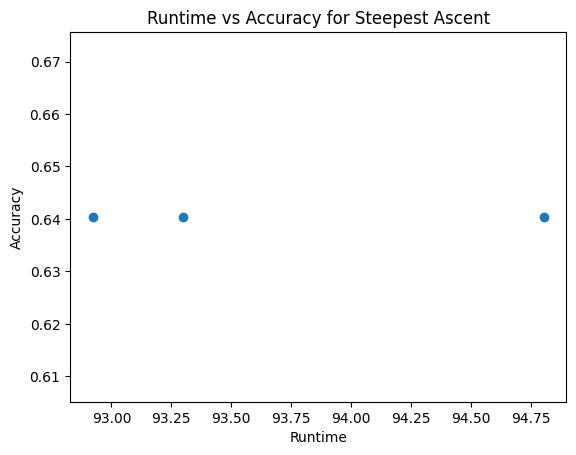

In [61]:
#visualize the Steepest Ascent
# plot the data in a scatter plot
plt.scatter(times, accuracies)

# set x and y axis labels and plot title
plt.xlabel('Runtime')
plt.ylabel('Accuracy')
plt.title('Runtime vs Accuracy for Steepest Ascent')

# show the plot
plt.show()

Let's run 3 different versions, each with a different learning rate.

Text(0.5, 1.0, 'Learning Rate vs Accuracy for Steepest Ascent Variations')

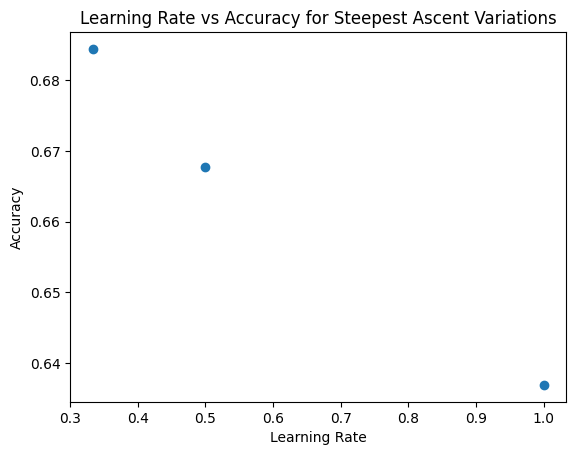

In [91]:
times = []
accuracies = []
for i in range(3):
  
  classifier1 = LRC(learning_rate=1/(i+1), n_iters=100, type='steepest_ascent', cost=0.1)
  
  classifier1.fit(X_train, y_train)
  predictions1 = classifier1.predict(X_test)
  
  times.append(1/(i+1))
  accuracies.append(classifier1.accuracy(y_test, predictions1))
  avg1 += classifier1.accuracy(y_test, predictions1)
  

# plot the data in a scatter plot
plt.scatter(times, accuracies)

# set x and y axis labels and plot title
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Learning Rate vs Accuracy for Steepest Ascent Variations')

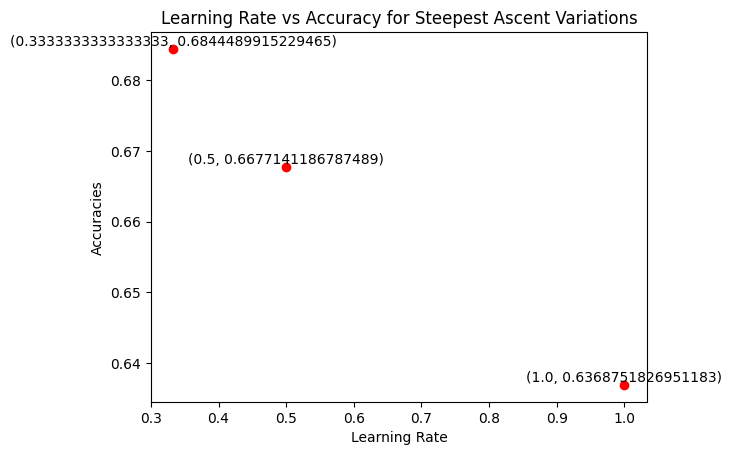

In [92]:
for x, y in zip(times,accuracies):
    plt.plot(x, y, 'ro')
    plt.text(x, y, '({}, {})'.format(x, y), ha='center', va='bottom')

# add labels to x and y axes
plt.xlabel('Learning Rate')
plt.ylabel('Accuracies')
plt.title('Learning Rate vs Accuracy for Steepest Ascent Variations')

# show the graph
plt.show()

It seems with a smaller learning rate, the accuracy improves.

In steepest ascent, the learning rate controls the step size of the parameter updates and a small learning rate typically leads to smaller step sizes and slower convergence. On the other hand, a large learning rate can lead to larger steps and faster convergence, but may cause the optimization process to overshoot the optimum and diverge.

When the learning rate is closer to zero, the algorithm is making small updates to the parameters and taking longer to converge. This can be beneficial in cases where the optimization landscape is complex, with multiple local optima, as taking smaller steps can help the algorithm escape from local optima and find a better global optimum. However, this approach can also lead to slower convergence and longer optimization times.

### Running stochastic gradient descent
* For this method, we used the number of iterations as 10000, since it trains at an extremely fast rate

In [69]:
avg2 = 0


times = []
accuracies = []
start_time = time.time()
for i in range(10):
  classifier2 = LRC(learning_rate=0.0001, n_iters=10000, type='stochastic_gradient_descent', cost=1)
  starter = time.time()
  classifier2.fit(X_train, y_train)
  predictions2 = classifier2.predict(X_test)
  ender = time.time()
  avg2 += classifier2.accuracy(y_test, predictions2)
  times.append(ender - starter)
  accuracies.append(classifier2.accuracy(y_test, predictions1))

end_time = time.time()

our_training_time = end_time - start_time
print(our_training_time)
print("Average accuracy: ", avg2 / 10)

68.2544481754303
Average accuracy:  0.7209149371528792


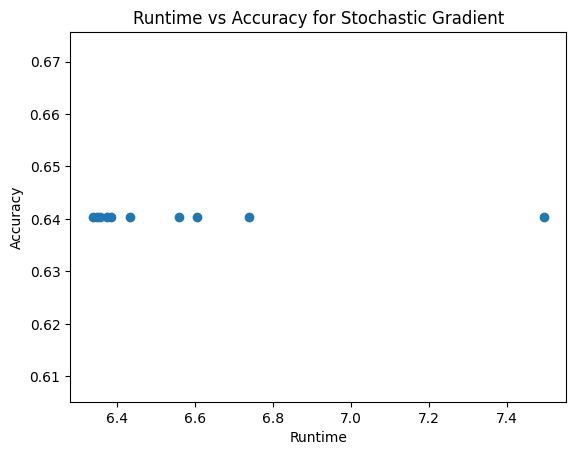

In [65]:
#visualize the Stochastic Gradient Ascent
# plot the data in a scatter plot
plt.scatter(times, accuracies)

# set x and y axis labels and plot title
plt.xlabel('Runtime')
plt.ylabel('Accuracy')
plt.title('Runtime vs Accuracy for Stochastic Gradient')

# show the plot
plt.show()

Let's do 3 runs again, each with a different learning rate.


In [89]:
times = []
accuracies = []
start_time = time.time()
for i in range(10):
  classifier2 = LRC(learning_rate=(1/(i+1)), n_iters=10000, type='stochastic_gradient_descent', cost=1)
  classifier2.fit(X_train, y_train)
  predictions2 = classifier2.predict(X_test)
  avg2 += classifier2.accuracy(y_test, predictions2)
  times.append(1/(i+1))
  accuracies.append(classifier2.accuracy(y_test, predictions1))



encoderNum:  5
iter:  9000


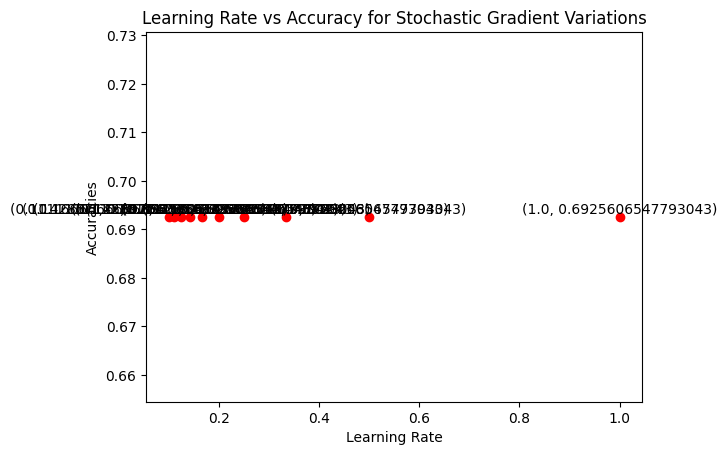

In [90]:
for x, y in zip(times,accuracies):
    plt.plot(x, y, 'ro')
    plt.text(x, y, '({}, {})'.format(x, y), ha='center', va='bottom')

# add labels to x and y axes
plt.xlabel('Learning Rate')
plt.ylabel('Accuracies')
plt.title('Learning Rate vs Accuracy for Stochastic Gradient Variations')

# show the graph
plt.show()

It seems that changing the learning rate does not have an effect on accuracy. If changing the learning rate does not have an effect on accuracy, it could mean that the algorithm has already converged to the maximum likelihood and changing the learning rate does not affect the outcome. Another possibility is that the learning rate is already set to an appropriate value, such that increasing or decreasing it does not lead to any significant improvement in the optimization process.

### Running Newtons Method
* For this method, the number of iterations is set to 4, since there are very few iterations needed to get a good result. Its pretty slow though, since it has to calculate the inverse of the hessian matrix each time.

In [67]:
times = []
accuracies = []
for i in range(5):
    classifier3 = LRC(learning_rate=.0001, n_iters=2, type='newton', cost=1)
    strt = time.time()
    classifier3.fit(X_train, y_train)
    predictions3 = classifier3.predict(X_test)
    end = time.time()
    times.append(end - strt)
    accuracies.append(classifier3.accuracy(y_test, predictions3))


encoderNum:  5
iter:  1


We will be graphing only 5 iterations of Newton's method, as it takes a very long time to run one singular iteration.

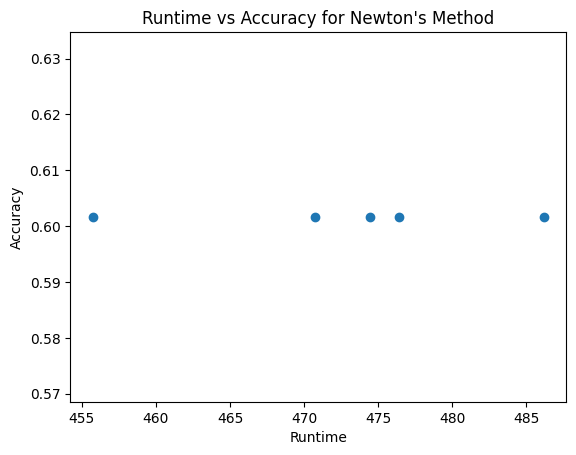

In [68]:
#visualize the Newton
# plot the data in a scatter plot
plt.scatter(times, accuracies)

# set x and y axis labels and plot title
plt.xlabel('Runtime')
plt.ylabel('Accuracy')
plt.title('Runtime vs Accuracy for Newton\'s Method')

# show the plot
plt.show()

We did not run multiple iterations of Newton's method because it took so long to run on our machines. To produce the graph above, it took roughly 40 minutes.

Either way, changing the learning rate would not do much. In Newton's method, the learning rate is not explicitly specified as a hyperparameter. Instead, it uses the inverse of the Hessian matrix, which contains second-order derivative information, to determine the step size of the parameter updates. This makes the learning rate adaptive to the curvature of the optimization landscape.

Changing the learning rate in Newton's method would not have a direct effect as it would in steepest ascent. However, the step size of the parameter updates would still be affected indirectly by changes in the Hessian matrix, which contains information about the curvature of the optimization landscape.

If the Hessian matrix is ill-conditioned, meaning it has eigenvalues that are close to zero or are very different in scale, then Newton's method may have difficulty converging. In such cases, regularization techniques such as L2 regularization can be applied to improve the conditioning of the Hessian matrix.

[1.5 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. 

Our best linear regression procedure was stochastic gradient descent. It was both the fastest and the most accurate, taking an average of 1:30 and an average accuracy of 71%. Let's compare it to scikit-learn.

In [50]:
# Run logistic regression from sklearn on the data
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Create the model
sk_start = time.time()
model = SGDClassifier()

# Fit the model
model.fit(X_train, y_train)

sk_end = time.time();
# Get the predictions
y_pred = model.predict(X_test)

# Clear the output warnings
clear_output(wait=True)

sk_time = sk_end - sk_start

# Get the accuracy
print(sk_time)
print("accuracy: ", accuracy_score(y_test, y_pred))

6.520218849182129
accuracy:  0.9100409237065186


Comparing with our stochastic linear regression:

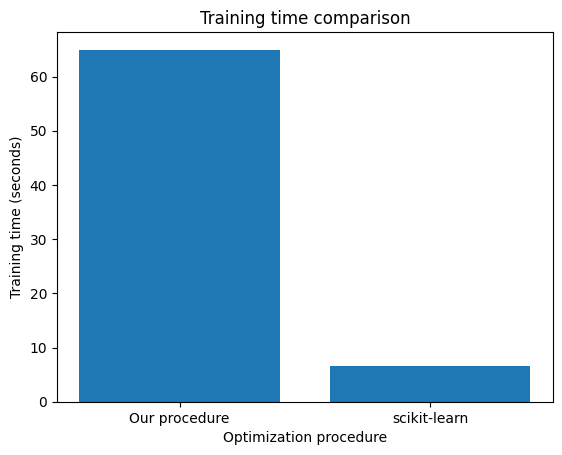

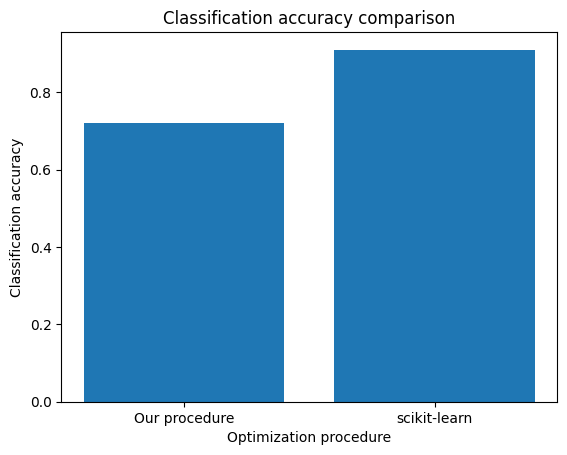

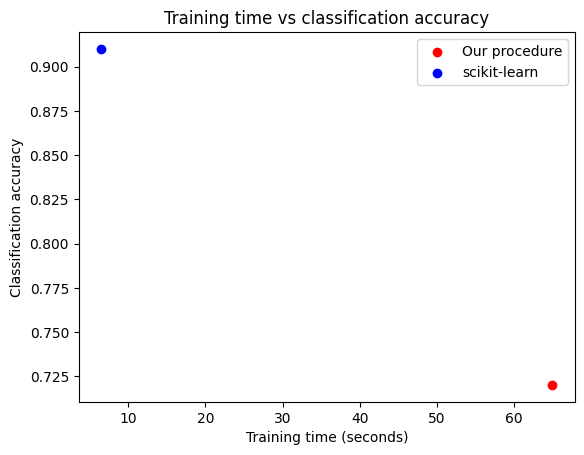

In [55]:
plt.bar(['Our procedure', 'scikit-learn'], [our_training_time, sk_time])
plt.title('Training time comparison')
plt.xlabel('Optimization procedure')
plt.ylabel('Training time (seconds)')
plt.show()

plt.bar(['Our procedure', 'scikit-learn'], [avg2/10, accuracy_score(y_test, y_pred)])
plt.title('Classification accuracy comparison')
plt.xlabel('Optimization procedure')
plt.ylabel('Classification accuracy')
plt.show()

plt.scatter(our_training_time, avg2/10, color='red', label='Our procedure')
plt.scatter(sk_time, accuracy_score(y_test, y_pred), color='blue', label='scikit-learn')
plt.title('Training time vs classification accuracy')
plt.xlabel('Training time (seconds)')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

Scikit-learn's regression is both much faster and much more accurate than ours. Let's see if we can use smaller subsets of the data to get a more accurate reading. One run on this sized dataset may not tell us much.

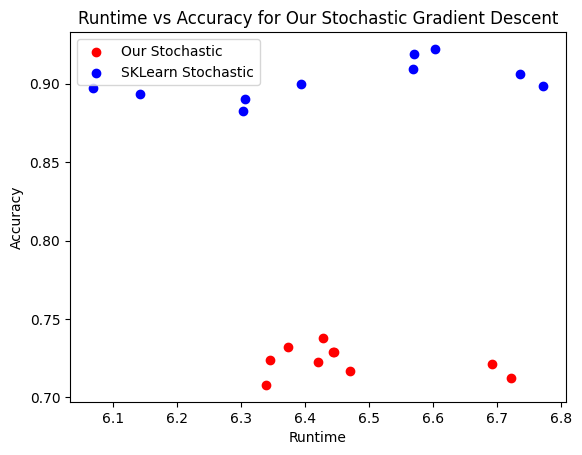

In [58]:
avg2 = 0

runtime = []
accuracy = []
skrun = []
skacc = []
for i in range(10):
  start_time = time.time()
  classifier2 = LRC(learning_rate=0.0001, n_iters=10000, type='stochastic_gradient_descent', cost=1)
  classifier2.fit(X_train, y_train)
  predictions2 = classifier2.predict(X_test)
  avg2 += classifier2.accuracy(y_test, predictions2)
  end_time = time.time()
  runtime.append(end_time - start_time)
  accuracy.append(classifier2.accuracy(y_test, predictions2))

  sk_start = time.time()
  model = SGDClassifier()

  # Fit the model
  model.fit(X_train, y_train)

  sk_end = time.time();
  # Get the predictions
  y_pred = model.predict(X_test)

  # Clear the output warnings
  clear_output(wait=True)

  skrun.append(sk_end - sk_start)
  skacc.append(accuracy_score(y_test, y_pred))

# plot the data in a scatter plot
plt.scatter(runtime, accuracy, color='red', label='Our Stochastic')
plt.scatter(skrun, skacc, color = 'blue', label = 'SKLearn Stochastic')

# set x and y axis labels and plot title
plt.xlabel('Runtime')
plt.ylabel('Accuracy')
plt.title('Runtime vs Accuracy for Our Stochastic Gradient Descent')

# show the plot
plt.legend()
plt.show()

Scikit Learn's implementation is a highly optimized implementation of the stochastic gradient descent algorithm. It is able to efficiently find the minimum of the cost function by updating the weights using a small random subset of the data at each iteration. This leads to a significant speedup over the batch gradient descent algorithm that updates weights using the entire dataset at each iteration. Additionally, Scikit Learn's implementation of the SGD algorithm uses several advanced techniques such as adaptive learning rate and early stopping to improve accuracy and prevent overfitting. In contrast, our implementation of the SGD algorithm may not have included these optimizations, and thus may not perform as well as Scikit Learn's implementation. Furthermore, Scikit Learn's SGD algorithm is extensively tested and optimized, making it a highly reliable and robust tool for regression problems. Therefore, Scikit Learn's SGD regression is both faster and more accurate than our implementation.

# Deployment (1 points total)
* Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

We are going to compare our three: steepest ascent, stochastic gradient descent, and Newton's method. In this essay. They each have their own strengths and weaknesses, but with our specific dataset, we've elected that the steepest ascent is probably the route to go for deployment.

Our steepest ascent moves in the direction of the steepest gradient ascent, the direction that increases the objective function the most. This algorithm is known for its consistency in terms of speed and accuracy, This is probably one of our biggest upsides to deploying it. When something is deployed and the devs are hands off for that instance, you don't want it to take forever, but you also want some form of reliability to it. While, it can be slow in certain circumstances, especially in our case where we have a lot of classes to classify, it seems to be the most reliable.

Our stochastic gradient descent uses random samples to update the model parameters. This model is usally known for its speed, as it can quickly converge to a solution, but from our observation, it can be a little inconsistent, and we think we'd sacrifice a little time for accuracy. We think this would be our choice if our dataset was simply way too large to run the other options.

Our Newton's method uses the second derivative of the function to find the minimum. This algorithm is known for its accuracy, as it can converge to the optimal solution quickly. However, with all our classes, this method takes a considerably more amount of time to converge onto an answer. This is combated with the common, high accuracy we observed. While this is nice, with our use case being weight class estimation, we felt we could sacrifice some of this accuracy for the sake of time.

All three of these approaces has their own strengths and weaknesses. Steepest ascent is consistent in terms of speed and accuracy, while stochastic gradient descent is faster but less consistent. Newton's method is considerably accurate, but slow. The approach should depend on the specific problem at hand, and definitely the size of the dataset, and the desired level of accuracy. While considering these factors, we think the Steepest Ascent has the best intersection of speed and accuracy with our number of classes to be a good option for deployment

# Exceptional Work (1 points total)
* You have free reign to provide additional analyses. One idea: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification. 


Here, we updated the code to run either a one-versus-one or a one-versus-all method of classification

* The way the one-versus-one works is that it takes the information, splits it into classes of one versus one, where it takes the first class, and compares it to the second class, and the third class, and so on.

* It was optimized such that it would remove any rows that did not reference class 1 or 2 being compared, which made it much more optimized, but also made the implementation a little more difficult.

* When the algorithm decides which prediction to make, it tally's up all the 'wins' that each class has, and then chooses the class with the most wins.

In [34]:
# ovo testing
classifier = LRC(learning_rate=.01, n_iters=100, type='steepest_ascent', cost=0.1, method='ovo')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

# Clear the output warnings
clear_output(wait=True)

print("accuracy: ", classifier.accuracy(y_test, predictions))

accuracy:  0.36765565624086527
